Model Loaded ✔


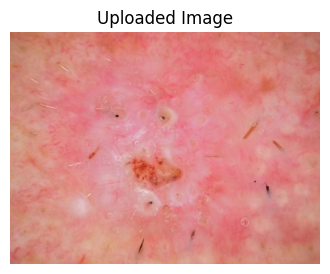

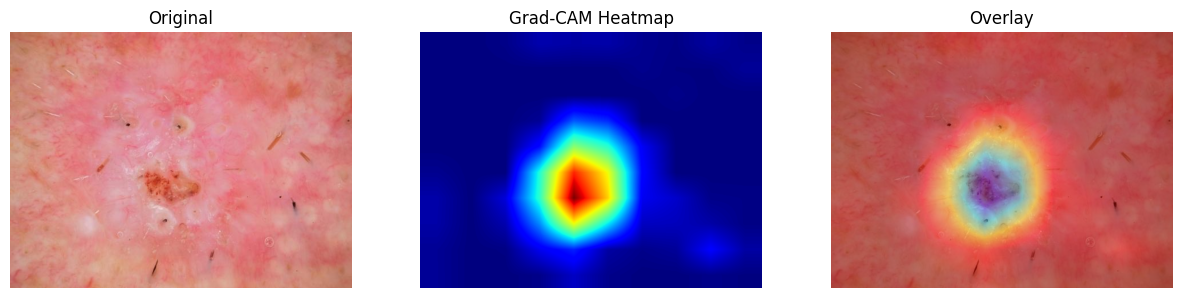

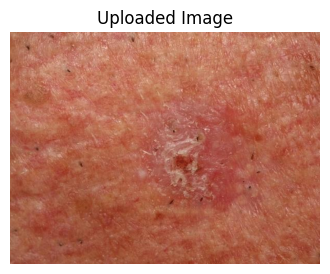

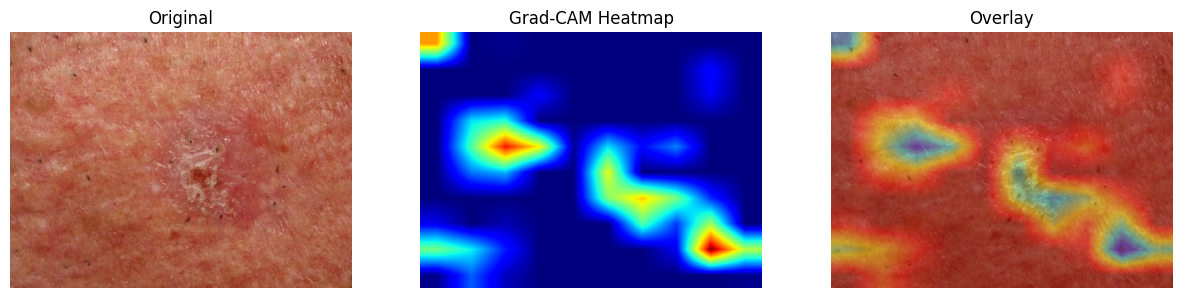

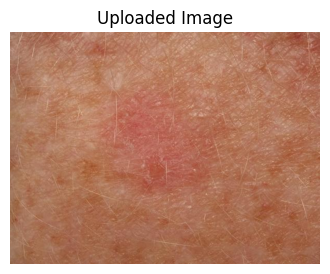

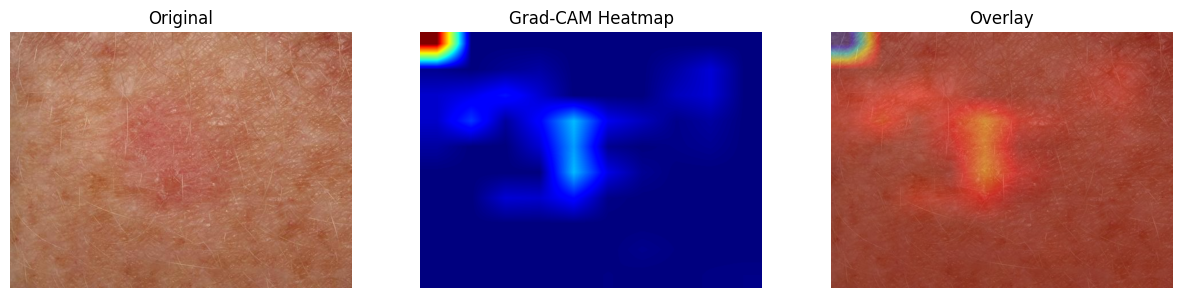

In [3]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from ipywidgets import FileUpload, VBox, Button
from IPython.display import display

# ========================================
# LOAD TRAINED MODEL
# ========================================
from model import MultimodalEfficientNetB3   # your model definition

CHECKPOINT = "best_multimodal_effb3.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MONET_DIM = 7   # <-- Update if different

model = MultimodalEfficientNetB3(monet_dim=MONET_DIM).to(DEVICE)
checkpoint = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model Loaded ✔")


# ========================================
# GRAD-CAM IMPLEMENTATION
# ========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, img_tensor, monet, meta):
        logits = self.model(img_tensor, monet, meta)
        pred_class = logits.argmax(dim=1).item()

        self.model.zero_grad()
        logits[0, pred_class].backward()

        gradients = self.gradients[0]       # [C,H,W]
        activations = self.activations[0]   # [C,H,W]

        weights = gradients.mean(dim=(1,2))  # GAP

        cam = torch.zeros(activations.shape[1:], dtype=torch.float32).to(DEVICE)

        for w, act in zip(weights, activations):
            cam += w * act

        cam = torch.relu(cam)
        cam = cam.cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam, pred_class


# ========================================
# IMAGE TRANSFORM
# ========================================
transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


# ========================================
# UPLOAD WIDGET
# ========================================
uploader = FileUpload(accept='.jpg,.png,.jpeg', multiple=False)

def on_upload_change(change):
    if uploader.value:
        file = uploader.value[0]   # FIXED
        img_bytes = file['content']

        from io import BytesIO
        img = Image.open(BytesIO(img_bytes)).convert("RGB")

        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.title("Uploaded Image")
        plt.axis("off")
        plt.show()

        run_gradcam_on_image(img)



def run_gradcam_on_image(img):
    orig = np.array(img)
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # Dummy MONET + metadata for GradCAM
    monet = torch.zeros((1, MONET_DIM)).float().to(DEVICE)
    meta  = torch.tensor([[30,1,3,5]], dtype=torch.float32).to(DEVICE)

    # GradCAM target
    target_layer = model.image_backbone.features[-1]
    cam_gen = GradCAM(model, target_layer)

    cam, pred_class = cam_gen.generate(img_tensor, monet, meta)

    cam_resized = cv2.resize(cam, (orig.shape[1], orig.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(cam_resized * 255), cv2.COLORMAP_JET)
    overlay = (orig * 0.6 + heatmap * 0.4).astype(np.uint8)

    # Display results
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam_resized, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()

    print(f"Predicted Class Index: {pred_class}")


uploader.observe(on_upload_change, names='value')

display(VBox([uploader]))


Model Loaded ✔ on cuda


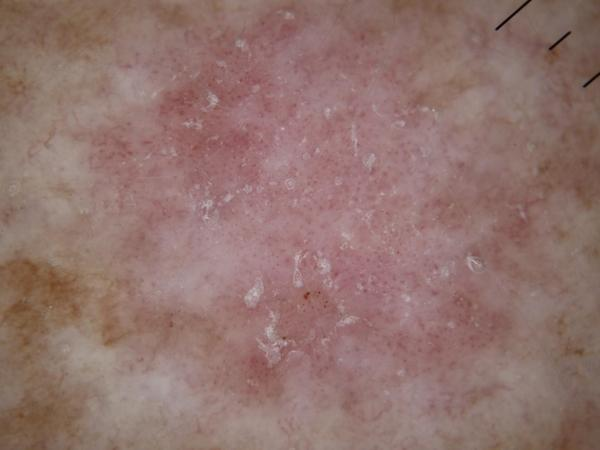

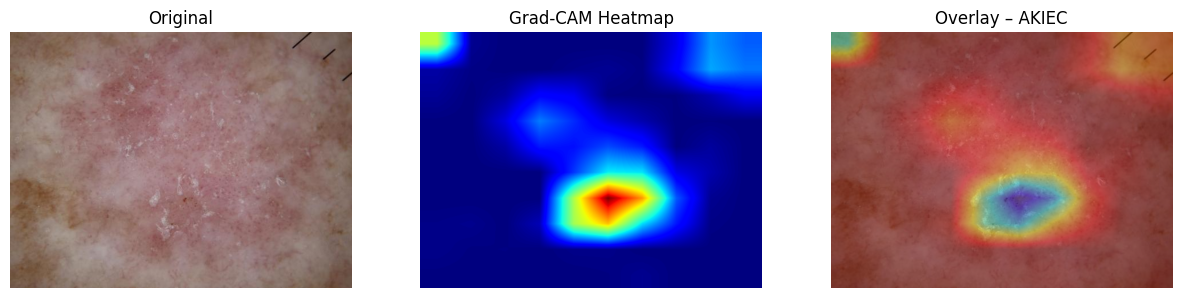

In [4]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from io import BytesIO

import ipywidgets as widgets
from IPython.display import display

# ============================================
# CONFIG
# ============================================
CHECKPOINT = "best_multimodal_effb3.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MONET_DIM = 7   # UPDATE: your model trained with 7 MONET features

CLASS_NAMES = [
    "AKIEC","BCC","BEN_OTH","BKL","DF",
    "INF","MAL_OTH","MEL","NV","SCCKA","VASC"
]

# ============================================
# LOAD MODEL
# ============================================
from model import MultimodalEfficientNetB3   # SAFE import

model = MultimodalEfficientNetB3(monet_dim=MONET_DIM).to(DEVICE)
ckpt = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("Model Loaded ✔ on", DEVICE)


# ============================================
# GRAD-CAM IMPLEMENTATION
# ============================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, img_tensor, monet, meta):
        logits = self.model(img_tensor, monet, meta)
        pred_class = logits.argmax(dim=1).item()

        self.model.zero_grad()
        logits[0, pred_class].backward()

        grads = self.gradients[0]
        acts = self.activations[0]

        weights = grads.mean(dim=(1,2))
        cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(DEVICE)

        for w, a in zip(weights, acts):
            cam += w * a

        cam = torch.relu(cam)
        cam = cam.cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam, pred_class


# ============================================
# IMAGE TRANSFORMS
# ============================================
transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])


# ============================================
# RUN GRAD-CAM ON UPLOADED IMAGE
# ============================================
def run_gradcam(img):

    orig = np.array(img)
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # NOTE: metadata is dummy only for Grad-CAM
    monet = torch.zeros((1, MONET_DIM), dtype=torch.float32).to(DEVICE)
    meta  = torch.tensor([[30,1,3,5]], dtype=torch.float32).to(DEVICE)

    cam_layer = model.image_backbone.features[-1]
    cam_generator = GradCAM(model, cam_layer)

    cam_map, pred_idx = cam_generator.generate(img_tensor, monet, meta)

    # Resize CAM to image size
    cam_resized = cv2.resize(cam_map, (orig.shape[1], orig.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(cam_resized * 255), cv2.COLORMAP_JET)
    overlay = (orig * 0.6 + heatmap * 0.4).astype(np.uint8)

    # Show results
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title(f"Overlay – {CLASS_NAMES[pred_idx]}")
    plt.axis("off")

    plt.show()

    # Print probability
    with torch.no_grad():
        logits = model(img_tensor, monet, meta)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    print(f"Prediction: {CLASS_NAMES[pred_idx]} ({probs[pred_idx]*100:.2f}%)")
    print("Class index:", pred_idx)


# ============================================
# FILE UPLOADER WIDGET (NEW API)
# ============================================
uploader = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)

def on_upload_change(change):
    if uploader.value:
        file = uploader.value[0]       # <- FIXED
        img_bytes = file['content']
        img = Image.open(BytesIO(img_bytes)).convert("RGB")

        print("\nImage Uploaded ✔")
        display(img)

        print("\nRunning Grad-CAM…")
        run_gradcam(img)

uploader.observe(on_upload_change, names='value')

display(widgets.VBox([widgets.Label("Upload a Dermoscopic Image"), uploader]))
